# Finding Bayesian Legos

by [Hank Roark](mailto:hroark@alum.mit.edu)

![Foot about to step on Lego](
http://www.sciencepart.com/wp-content/uploads/2016/03/stepping-on-LEGO-696x521.jpeg)

*Image from www.sciencepart.com*

Joe, a good family friend, dropped by earlier this week.  As we do often, we discussed the weather (seems to be hotter than normal already here in the Pacific Northwest), the news (mostly about how we are both taking actions to avoid the news), and our kids.  Both of us have children that really enjoy playing with Legos (tm).  And with Legos inevitably comes [the intense pain of stepping on Legos](http://www.sciencepart.com/feel-pain-stepping-lego/), usually in the middle of the night or first thing in the morning on the way to make coffee.  Stepping on lingering Legos seems to happen despite Joe and I both following after our children, picking up all the Legos we can find that the children left behind.

Joe and I keep batting around ways to decrease the chance of stepping on Legos.  After some time, I suggest we might be able to use probability and statistics to estimate the probability of there being Legos not removed in our sweeps after the kids.  Joe says he's on board, "Anything, my feet cannot take anymore!".

I fire up my favorite tools for estimating probabilities, and Joe and I get started on ways we might be able to estimate the likelihood there are Legos remaining after our sweeps to pick up the Legos missed by our children.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

np.random.seed(42)  # It's nice to replicate even virtual experiments

In [2]:
import pymc3 as pm
import scipy.stats as stats
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


## Experimentalists do it twenty times

Each person seems to have a different approach to picking up Legos.  For Joe, he said he makes sweeps after his kids, picking up remaining Legos.

My first suggestion to Joe is that if we know how good he is at picking up Legos in each sweep, then we can determine the probability that there are Legos left behind after each sweep.  Mathematically this is

$$p_{Lego\, remaining} = (1 - p_{Pickup\, Lego\, per\, sweep})^{n_{sweeps}}$$

Where $p_{Pickup\, Lego\, per\, sweep}$ is the probability of picking up a Lego in a single sweep, $n_{sweeps}$ is the number of sweeps Joe performs, and $p_{Lego\, remaining}$ is the cumulative probability of a Lego remaining after Joe completes all his sweeps.

I suggest to Joe an experiment to determine how good he is at picking up Legos:  I will go to the room where his children play with Legos and spread a random number of Legos on the floor, representing the number of Legos Joe's children leave behind for him to find.  Joe will follow behind me, in one of his typical sweeps of the room, picking up the Legos he finds.  

We will need to repeat this experiment some number of times, I estimate 20 times, to converge to an estimate of Joe's effectivity of picking up Legos.  At this point, Joe says, "Hey, I said I was in on finding a solution, but doing twenty repeats of picking up Legos is not my idea of fun.  You will need to prove to me it is worth my time."  I agree this experiment seems like it might harm the subject, Joe, so I decide to demonstrate for Joe how this might work before we proceed with the actual experiment.

I design the (virtual) experiments, spreading about a random number of Legos for each experiment.  Based on some estimates from Joe, to best represent the actual conditions of the number of Legos left behind by Joe's children, I pick a Normal (aka Gaussian) distribution of Legos, centered around a mean of 100 Legos and a standard deviation of 20 Legos for each experiment:

$$ N_0 \sim \mathcal{N}(\mu=100,\,\sigma^{2}=20) $$

where $N_0$ is the number of Legos left behind to be found by Joe.

In [3]:
mean = 100
standard_deviation = 20
experiments = 20
N_0 = (np.random.randn(experiments)*standard_deviation+mean).astype(int)
N_0

array([109,  97, 112, 130,  95,  95, 131, 115,  90, 110,  90,  90, 104,
        61,  65,  88,  79, 106,  81,  71])

In [4]:
# This cell is hidden because we don't know how good Joe is actually 
# in picking up Legos.  We will reveal the value at the end of the experiments
# for comparison
alpha = 30
beta = 10 
mean_actual_prob = alpha / (alpha + beta)
actual_prob = np.random.beta(a=alpha, b=beta, size=experiments)

### Picking Up the Legos

Then if we were running an actual experiment, after each time I spread Legos around, Joes would follow behind me and pick up the Legos.  To simulate this in the virtual experiment I model the number of Legos Joe picks up using the binomial distribution.  Think of this as for each Lego on the ground Joe will either pick it up or not pick it up, based on Joes unknown probability of picking up a lego.f

$$ X \sim Bin(n=N_0, p) $$

where $X$ is the number of Legos Joe finds and $p$ is the unknown probability of Joe picking up a Lego.    This also assumes that Joe is fairly consistent in picking up Legos pass-to-pass with the model having a single probability $p$.

In [5]:
X = np.random.binomial(N_0, actual_prob)  
X

array([ 87,  66,  80, 110,  76,  65,  95,  92,  61,  83,  57,  76,  77,
        46,  49,  75,  54,  75,  61,  54])

A histogram shows the distribution of the percentage of Legos Joes has picked up in each trial of the virtual experiment.

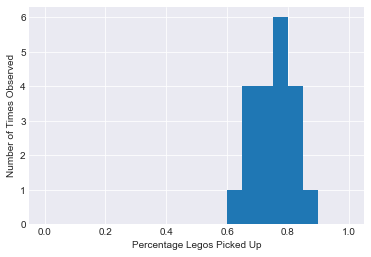

In [6]:
plt.hist(X / N_0, range=(0,1), bins=20)
plt.xlabel("Percentage Legos Picked Up")
plt.ylabel("Number of Times Observed")
plt.show();

### Modeling Joe

At this point we have a model of how many Legos Joe picks up his experimental trial sweeps, using the binomial distribution; and we know how many Legos were left behind in each experiment $N_0$d; and we know how many Legos Joe picks up on each experimental trial sweep $X$.  What we do not know is the probability of Joe picking up a Legos, so we need to model the probability.

A common model of a probability distribution is the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).  There are many reasons to use a beta distribution in this example.  The beta distribution is the conjugate prior of the binomial distribution; this reason is an algebraic convenience and less important for this example as we will use numeric integration.  More importantly, is that the beta distribution is an appropriate distribution for modeling percentages or proportions as random variables.

In our example, we will use a [weakly informative prior](http://www.stat.columbia.edu/~gelman/presentations/weakpriorstalk.pdf), one that estimates that Joe's probability of picking up a Lego is in the range of $[0,1]$, with a higher likelihood of being near the center of that range.  This says we know a little about Joe's skills in picking up Legos and encompass that into the model.  The beta distribution is parameterized by two values, typically called $\alpha$ and $\beta$.  I pick values that match the goals of a weakly informative prior with a mode being at $0.5$.


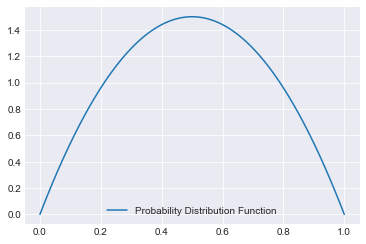

In [7]:
alpha_prior=2
beta_prior=2

x_locs = np.linspace(0, 1, 100)
plt.plot(x_locs, stats.beta.pdf(x_locs, alpha_prior, beta_prior), label='Probability Distribution Function');
plt.legend(loc='best');

### Model Fitting

Now we have a complete model of what could have generated the observed data (even if so far this is only a thought experiment):

$$ p \sim \mathcal{B}(alpha, beta) \\
   X \sim Bin(n=N_0, p)
$$

I agree with Joe that is the 2010's, and using [PyMC3](https://docs.pymc.io/) is cool.  There is much documentation and [a good introduction available](https://docs.pymc.io/notebooks/getting_started.html); I won't repeat that information here and instead will skip straight to modeling. 

First we build the model object:

In [8]:
basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha_prior, beta=beta_prior)
    x = pm.Binomial('x', n=N_0, p=p, observed=X)

Then I will fit the model, using the default No-U-Turn sampler (NUTS):

In [9]:
with basic_model:
    trace_basic = pm.sample(50000, random_seed=123, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:55<00:00, 1828.39draws/s]


Now we can look at some results of the model fitting.  In this case, the estimated actual based probability on the data and given the model (also known as the posterior probability) of my friend Joe picking up a Lego in a pass is $75\%$, with a $95\%$ confidence interval being $[73\%, 77\%]$.  I also plot the prior probability (the weakly informative prior using the beta distribution) compared to the posterior distribution for comparison.


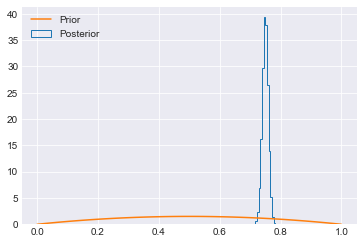

In [10]:
plt.hist(trace_basic['p'], 15, histtype='step', density=True, label='Posterior');
plt.plot(x_locs, stats.beta.pdf(x_locs, alpha_prior, beta_prior), label='Prior');
plt.legend(loc='best');

In [11]:
basic_model_df = pm.summary(trace_basic)
basic_model_df.round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.75,0.01,0.0,0.73,0.77,40081.98,1.0


### Model Joe, Again

Joe and I take some time with this model, to see if it fits what we sense of reality.  After all, for this to work, Joe needs to perform the experiment about twenty times and he wants some confidence that it is worth his time.

Making the safe assumption that Joe regularly performs at the lower end of the $95\%$ confidence interval, the first thing we have learned is that after 4 sweeps of a room there is less than $1\%$ chance that there are any Legos remaining to be picked up.

In [12]:
(1-basic_model_df.loc['p','hpd_2.5'])**4

0.0052992694812835335

Overall Joe and I are happy with the model, but we have this suspicion that something needs refinement.  Joe says he regularly makes four passes at picking up Legos, but still seems to always step on Legos the next time through the room.  Joe and I chat more and I learn that sometimes he makes quick sweeps and sometimes he makes rather detailed sweeps through the room.

When we initially modeled Joe, we assumed that Joe's probability of picking up a Lego was consistent pass-to-pass.  All statistical models miss something and our original model is no different.  What we have learned now is the probability of picking up a straggling Lego is different pass to pass.  This new understanding of what generates the observed data now needs to be included in the model.

There is a model for this, called the [Beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution).  The Beta-binomial distribution relaxes the assumption that there is a single probability for each binomial trial, modeling that there is a different probability parameter for each binomial trial.  This matches with what Joe describes as his process, with some sweeps being quick, and some being quite detailed.  Our new model looks like this:

$$
   X \sim BetaBin(\alpha, \beta, n=N_0)
$$

And we can model this directly in PyMC3.  To do this, we provide the half-Cauchy distribution as a [weakly regularizing priors](http://www.stat.columbia.edu/~gelman/presentations/wipnew2_handout.pdf) for the $\alpha$ and $\beta$ parameters of the beta-binomial distribution.  We use the half-Cauchy distributions as a way to 'encourage' the $\alpha$ and $\beta$ values to be closer to zero than would happen if the priors were set as uniform distributions.  The half-Cauchy distribution is supported on the range of $(0,\inf]$.  With that, we have a complete model:

$$
    \alpha \sim Cauchy^+( \beta = 2 ) \\
    \beta \sim Cauchy^+( \beta = 2 ) \\
    X \sim BetaBin(\alpha, \beta, n=N_0)
$$


In [13]:
model_bb = pm.Model()

with model_bb:
    alpha_bb = pm.HalfCauchy('alpha_bb', beta = 2.)
    beta_bb = pm.HalfCauchy('beta_bb', beta = 2.)
    X_bb = pm.BetaBinomial('X_bb', alpha=alpha_bb, beta=beta_bb, n=N_0, observed=X)

In [14]:
with model_bb:
    trace_bb = pm.sample(50000, tuning=5000, random_seed=123, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_bb, alpha_bb]
Sampling 2 chains: 100%|██████████| 101000/101000 [03:05<00:00, 544.28draws/s]
The acceptance probability does not match the target. It is 0.8815090771222175, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


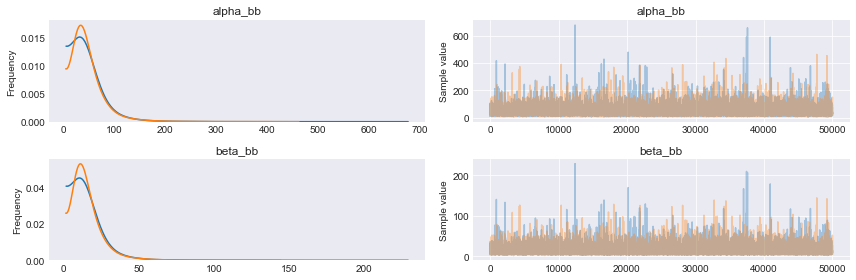

In [15]:
pm.traceplot(trace_bb);

In [16]:
pm.summary(trace_bb)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_bb,46.219269,32.431405,0.280427,8.312109,102.314422,13121.517392,1.000296
beta_bb,15.528074,10.791256,0.093386,2.992828,34.185840,13107.035942,1.000285


With this new parameterization, we have lost a direct connection with the probability parameter.  This is needed so Joe can determine how many passes he needs to make to reach his desired level confidence that all of the Legos have been removed, and his feet will be safe to walk the floors at night.  

In PyMC3, we can determine the overall probability posterior estimate by generating data based on the fit model.  PyMC3 has a simple way to do this using [posterior predictive checks](https://docs.pymc.io/notebooks/posterior_predictive.html).  I will generate 1000 examples of the posterior probability.

In [17]:
with model_bb:
    p_bb = pm.Beta('p_bb', alpha=alpha_bb, beta=beta_bb)
    ppc = pm.sample_posterior_predictive(trace_bb, 1000, vars=[p_bb])

100%|██████████| 1000/1000 [00:24<00:00, 41.64it/s]


With this, Joe and I compare the results using the beta-binomial assumption (different probability for each binomial trial, or sweep of the floor for Legos) to the binomial assumption (single probability for all binomial trials).  As we learn and expected the distribution of probabilities in the beta-binomial model assumption is wider than compared to the binomial assumption.

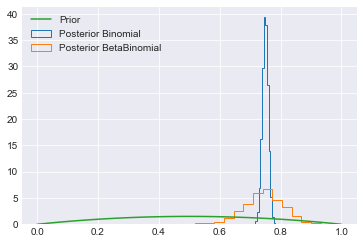

In [18]:
plt.hist(trace_basic['p'], 15, histtype='step', density=True, label='Posterior Binomial');
plt.hist(ppc['p_bb'], 15, histtype='step', density=True, label='Posterior BetaBinomial');
plt.plot(x_locs, stats.beta.pdf(x_locs, alpha_prior, beta_prior), label='Prior');
plt.legend(loc='best');

In [19]:
bb_quantiles = np.quantile(ppc['p_bb'], [0.025, 0.5, 0.975])
bb_quantiles

array([0.59356599, 0.74900266, 0.86401046])

Again, making the safe assumption that Joe regularly performs at the lower end of the $95\%$ confidence interval, the first thing we have learned is that after 7 sweeps of a room there is less than $1\%$ chance that there are any Legos remaining to be picked up.

In [20]:
(1-bb_quantiles[0])**7

0.0018320202853132318

#### Final word: Model compared to generating function

Remember, back at the beginning all of this was a thought exercise, to see if it is worth Joe performing an experiment 20 times so we could determine the probability of Joe picking up a Lego in a sweep.  In this thought exercise, we generated data that was how many Legos Joe picked up each of the 20 experimental sweeps.  Now that we are done modeling, we can explore the actual data generating function and compare it to the models.  The practice of generating data and then recovering parameters, to validate the modeling approach at a minimum recover the original parameters, is a best practice in computational statistics.

This parameters for the generating function is available in the Jupyter notebook, in a hidden cell near the beginning.

As can be seen below, the original generating function of the probabilities of picking up a Lego in a pass was a beta distribution generated probability for each sweep Joe makes.  From this, we can see that the beta-binomial model did a better job of recreating the original generating function from the generated data compared to the binomial model.  The binomial model did not account for the variability in the quality of the job Joe did pass to pass, whereas the beta-binomial model did.

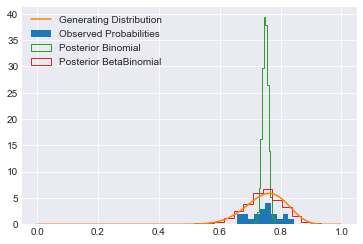

In [21]:
plt.hist(actual_prob, label='Observed Probabilities')
plt.plot(x_locs, stats.beta.pdf(x_locs, alpha, beta), label='Generating Distribution');
plt.hist(trace_basic['p'], 15, histtype='step', density=True, label='Posterior Binomial');
plt.hist(ppc['p_bb'], 15, histtype='step', density=True, label='Posterior BetaBinomial');
plt.legend(loc='best');

## Joe Doesn't Want To Do It Twenty Times
Joe and I are happy with the virtual experiment and are confident that by performing the experiment, we can learn about the probability Joe has of picking up a Lego during a pass.  But Joe still doesn't want to do the experiment, "Not twenty times, not once.  I hate picking up Legos, why would I do it over and over just to learn a parameter about myself.  Surely, Hank, there has to be a better way."

Joe and I start exploring different ways we might be able to help him gain confidence all the Legos have been picked up, without having to perform experiments on Joe.  Stay tuned to next time.